In [18]:
import glob
import pandas as pd
import pathlib
import cooler
import numpy as np
import subprocess
from cooltools import insulation
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [3]:
output_dir = 'domain_boundary_strength'
p = pathlib.Path(output_dir)
p.mkdir(parents=True, exist_ok=True)

In [4]:
res = 25000
ct = 'DG_Glut'

In [5]:
data_dir = '/data/female-amb/AMB.CoolFiles/CellType.Age.Raw.5kb.mcool' 
#data_dir = '/data/female-amb/impute/merged-25k'

In [6]:
leg = [f"{ct}.{age}" for age in ['8wk','18mo']]

In [7]:
import cooltools

In [8]:
# for group in leg:
#     cell_table_path = f'{data_dir}/{group}.raw.mcool'
#     clr = cooler.Cooler(f'{cell_table_path}::resolutions/{res}')
#     cell_table_path = f'{data_dir}/{group}.raw.mcool'
#     clr = cooler.Cooler(f'{cell_table_path}::resolutions/{res}')
    
#     # Perform ICE normalization
#     try:
#         # Normalize and store weights directly in the cooler file
#         cooler.balance_cooler(clr, mad_max=5, ignore_diags=2, tol=1e-5, min_nnz=10, min_count=10)
#         print(f"Weights computed and added for {group} at resolution {res}")
#     except Exception as e:
#         print(f"An error occurred while normalizing {group} at resolution {res}: {e}")
    
    
#     # Add the weights to the Cooler file
#     bins = clr.bins()[:]
#     bins['weight'] = weights
#     break

In [13]:
result = []
for group in leg:
    cell_table_path = f'{data_dir}/{group}.raw.mcool'
    clr = cooler.Cooler(f'{cell_table_path}::resolutions/{res}')
    # cell_table_path = f'{data_dir}/{group}.Q.cool'
    # clr = cooler.Cooler(f'{cell_table_path}')
    windows = [1*res]
    insulation_table = insulation(clr, 
                              windows, 
                              clr_weight_name=None,
                              verbose=True, ignore_diags =0
                              )
    insulation_table.index = insulation_table['chrom'].astype(str) + '_' + (insulation_table['start']//res).astype(str)
    
    tmp = insulation_table[['log2_insulation_score_25000','boundary_strength_25000']]
    tmp.columns = [f"{group}.ins_score",f"{group}.strength"]
    result.append(tmp)

result = pd.concat(result, axis = 1)

INFO:root:fallback to serial implementation.
INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chrX
INFO:root:fallback to serial implementation.
INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root

In [14]:
##select all age diff domain
binall = pd.read_hdf(f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', key='data')
selb = (binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'])
selected_bins = selb[selb].index
len(selected_bins)

777

In [15]:
strength = result[result.index.isin(selected_bins)]

In [16]:
## Load boundary probability
ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]
bound_prob_ct

,chr1_0,chr1_1,chr1_2,chr1_3,chr1_4,chr1_5,chr1_6,chr1_7,chr1_8,chr1_9,...,chr19_2448,chr19_2449,chr19_2450,chr19_2451,chr19_2452,chr19_2453,chr19_2454,chr19_2455,chr19_2456,chr19_2457
DG_Glut.8wk,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006289,0.076869,0.009783,0.003494,0.004892,0.002795,0.0,0.0,0.0,1.0
DG_Glut.18mo,0.999301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009085,0.078267,0.013277,0.004193,0.002795,0.003494,0.0,0.0,0.0,1.0


In [19]:
use_prop = bound_prob_ct.T.loc[selected_bins]
use_prop['prob_change'] = use_prop[f"{ct}.18mo"] - use_prop[f"{ct}.8wk"]

In [20]:
strength['strength_change'] = strength[f"{ct}.18mo.ins_score"] - strength[f"{ct}.8wk.ins_score"]

In [21]:
toplot = pd.concat([use_prop['prob_change'],strength['strength_change'] ], axis = 1)

[(-0.1, 0.1), (-2.0, 2.0)]

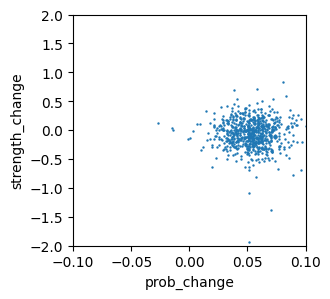

In [22]:
fig, ax  = plt.subplots(figsize = (3,3), dpi = 100)
sns.scatterplot(data = toplot,ax = ax,s =3, linewidth = 0,
               x = 'prob_change',y = 'strength_change')
ax.set(xlim = (-0.1, 0.1), ylim= (-2, 2))